In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.model import UnetDecodeNoBn
import shutil
from torch.utils.tensorboard import SummaryWriter
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.gmm_loss import PointProcessGaussian

from decode_fish.funcs.visualization import *
from decode_fish.funcs.routines import *

import ipyvolume as ipv

base_path =  '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/'

In [89]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

# Training

Load base config

In [90]:
cfg = OmegaConf.load('config/train.yaml')

Make dataset specific changes

In [91]:
cfg.output.project = 'scrib_smFISH'

cfg.run_name ='scrib_smFISH_2_3'

cfg.data_path.image_path = base_path + '/datasets/CodFish/smFISH_data_Titlow/scrib_smFISH_2.tif'
cfg.data_path.psf_path = None
cfg.ground_truth = None

cfg.bg_estimation.smoothing_filter_size = 3

cfg.foci.n_foci_avg = 1

cfg.evaluation.txt_path = None
cfg.evaluation.crop_sl = 's_[:,:,175:225,400:450]'
cfg.evaluation.px_size_zyx =  [100,100,100]

cfg.PSF.gauss_radii = [1.5,1.0,1.0]

cfg.microscope.int_conc = 4.
cfg.microscope.int_rate = 1
cfg.microscope.int_loc = 0.5

cfg.prob_generator.low= 0.0001
cfg.prob_generator.high= 0.001

cfg.training.num_iters = 20000
cfg.training.start_micro = 3000
cfg.training.start_psf = 3000

cfg.noise.theta = 1.5
cfg.noise.baseline = 0.

Store the config as an experiment

In [92]:
OmegaConf.save(cfg, f'config/experiment/{cfg.run_name}.yaml')

In [93]:
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (39, 48, 48)
1 volumes


Plot projections of the volume

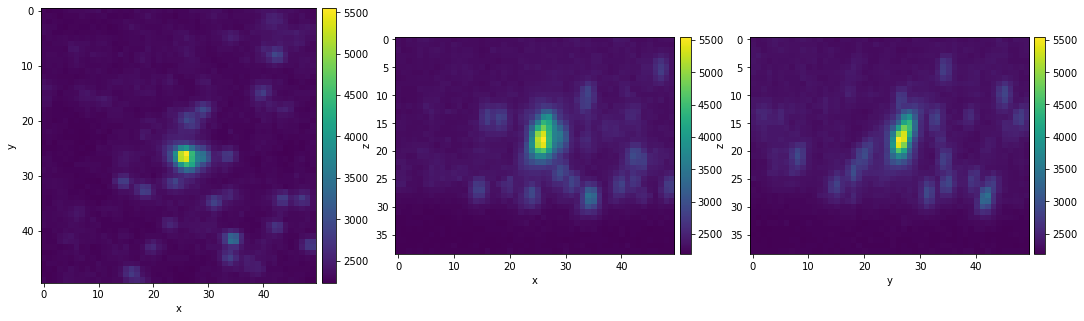

In [80]:
crop_sl = eval(cfg.evaluation.crop_sl,{'__builtins__': None},{'s_': np.s_})
_ = plot_3d_projections(img_3d[cfg.evaluation.img_ind][crop_sl[1:]], 'max')

Plot a sample from our dataloader showing a slice from the input volume and from a simulated training volume

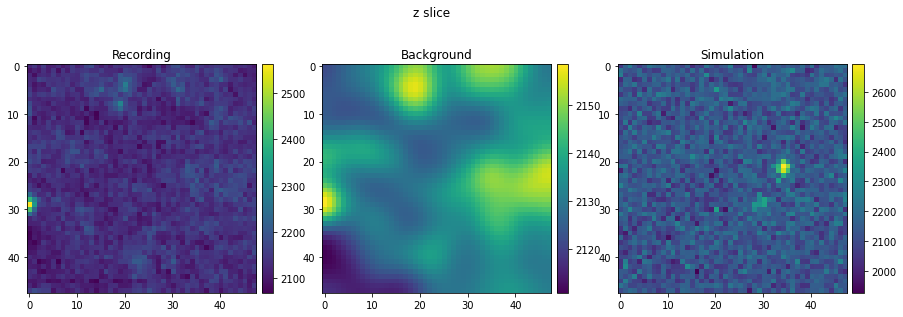

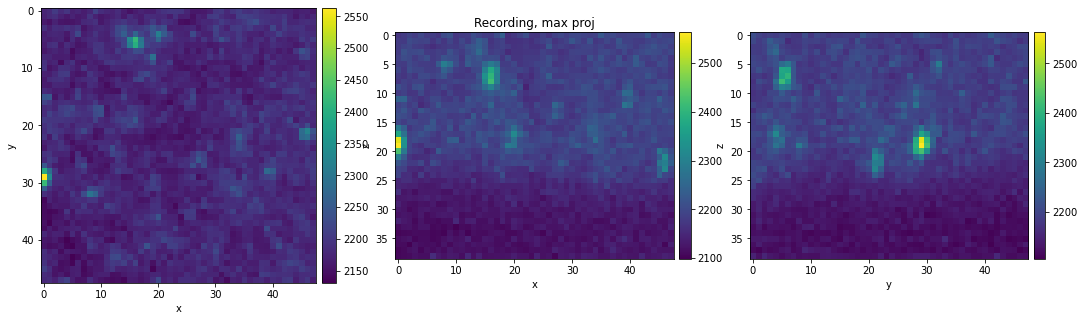

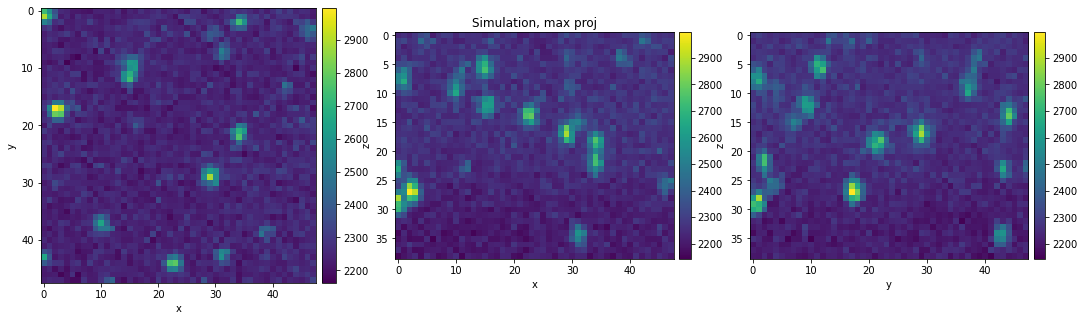

In [86]:
get_simulation_statistics(decode_dl, micro, int_threshold=1000)

Command to train a model on the gpu cluster

In [85]:
home_dir = os.getenv("HOME")
f'bsub -gpu "num=1" -q gpu_any -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode2_dev/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name}'

'bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode2_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=scrib_smFISH_2_3'

# Evaluation

In [94]:
cfg = OmegaConf.load(f'config/experiment/scrib_smFISH_2_3.yaml')
cfg.data_path.image_path = base_path + '/datasets/CodFish/smFISH_data_Titlow/scrib_smFISH_4.tif'

In [95]:
model, post_proc, psf, micro, img_3d, decode_dl = load_all(cfg, False)
psf_init = get_gaussian_psf(cfg.PSF.psf_extent_zyx,cfg.PSF.gauss_radii)
psf_init = cpu(psf_init.psf_volume[0])
psf_vol = cpu(psf.psf_volume[0])

Crop size larger than volume in at least one dimension. Crop size changed to (46, 48, 48)
1 volumes


In [20]:
img_3d, decode_dl = get_dataloader(cfg)

Plot projections of the PSF before and after optimizing it during training

(tensor(10.0000, device='cuda:0', grad_fn=<DivBackward0>), tensor(10.0000, device='cuda:0', grad_fn=<DivBackward0>), tensor(10.0000, device='cuda:0', grad_fn=<DivBackward0>))
Sum:  58.960682 23.624414
CSum:  59.651745 23.624414


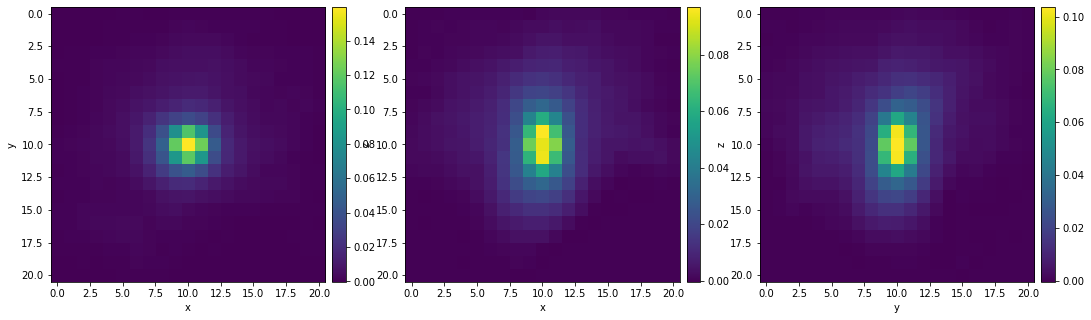

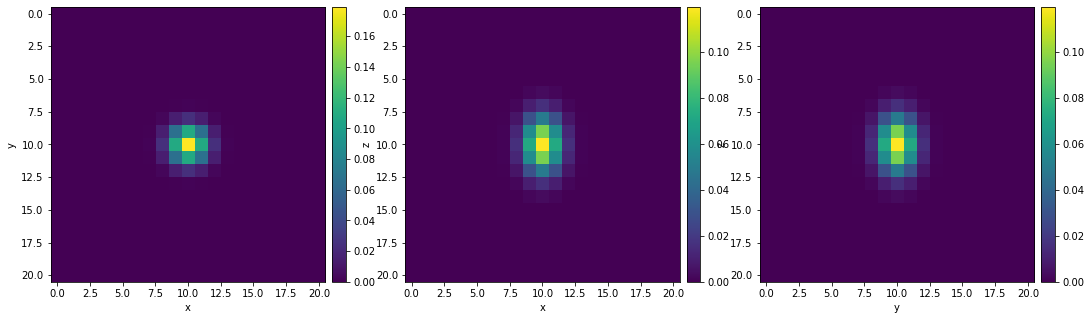

In [97]:
print(psf.get_com())
plot_3d_projections(psf_vol)
plot_3d_projections(psf_init)
print('Sum: ',  psf_vol.sum(), psf_init.sum())
print('CSum: ', np.clip(psf_vol,0,10).sum(), psf_init.sum())

Sample random sub volumes and overlay them with predictions, also show the reconstructions from applying the microscope and psf model to those predictions

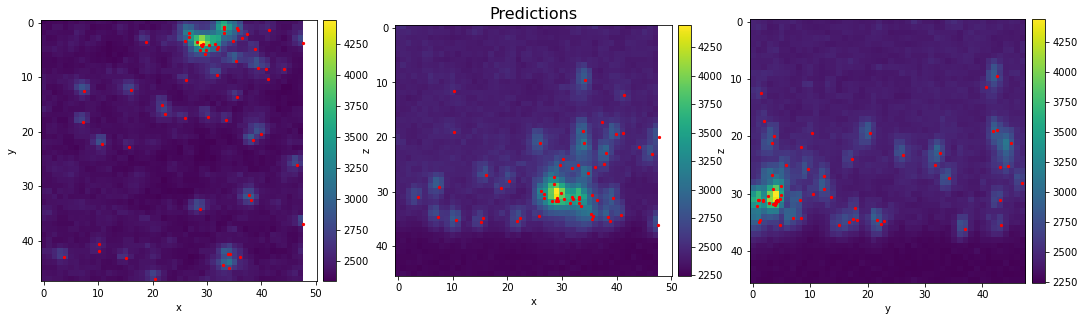

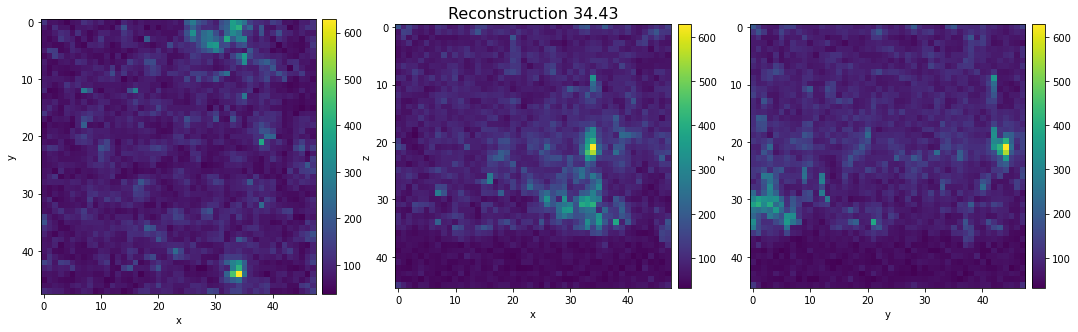

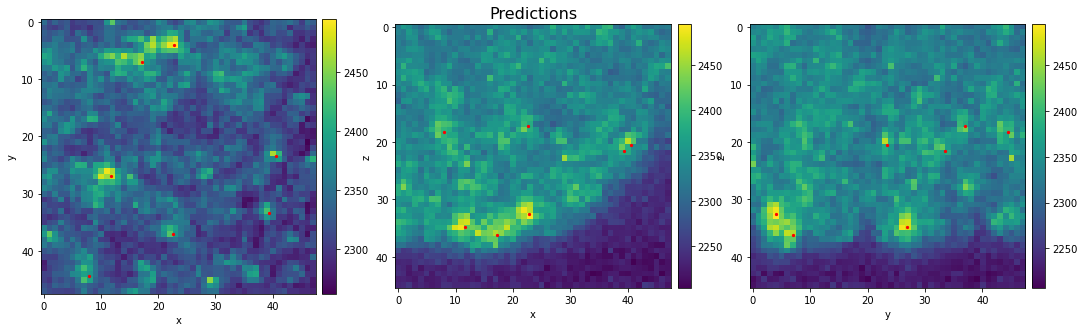

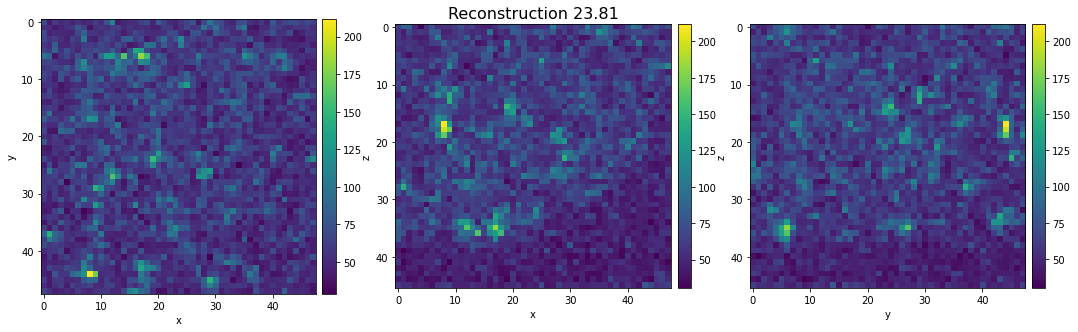

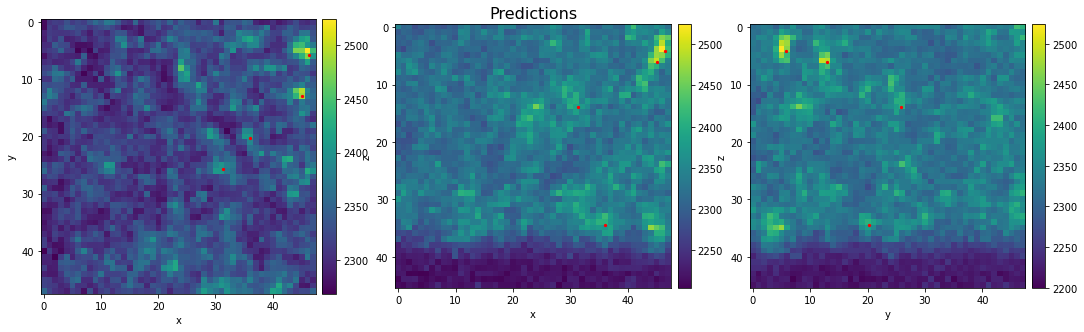

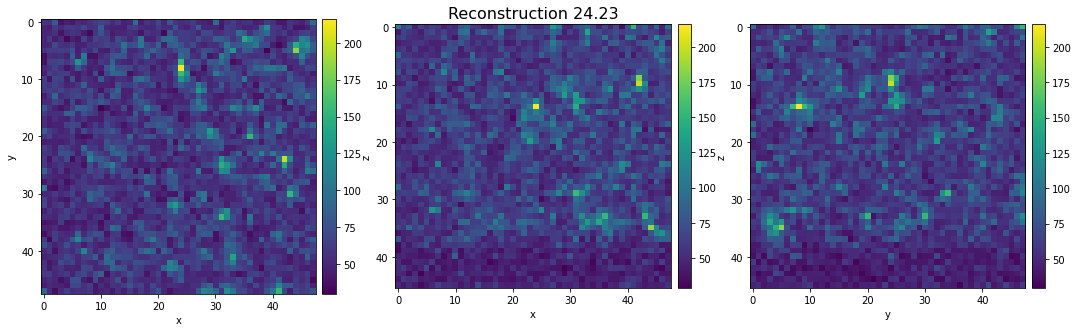

In [108]:
eval_random_crop(decode_dl, model, post_proc, micro, projection='max', samples=3)

In [109]:
xsim, gt = sim_data(decode_dl, 10, micro)
perf, pred_df, matches = get_sim_perf(xsim, px_to_nm(gt, cfg.evaluation.px_size_zyx), model, post_proc, micro, print_res=True)

NameError: name 'sim_data' is not defined

Volume with Foci? Max projection of real volume, reconstruction, difference

AttributeError: 'list' object has no attribute 'mean'

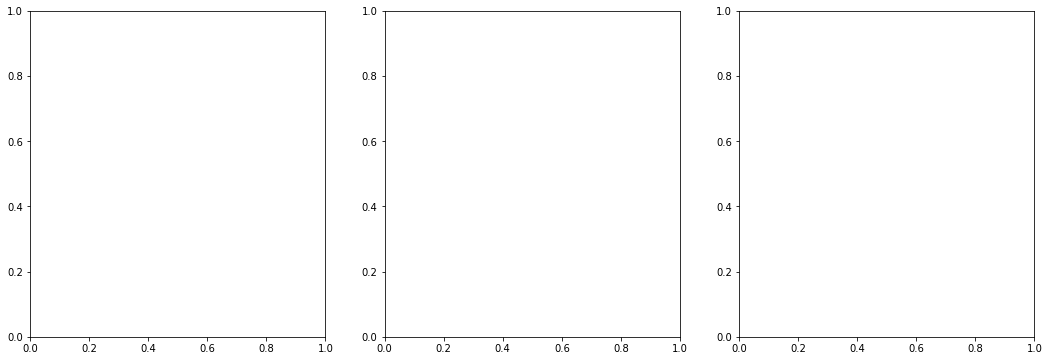

In [102]:
_ = plot_3d_projections(img_3d)

In [103]:
pred_df, gt_rec, res_dict = get_prediction(model,post_proc,img_3d[:,300:400,400:500], micro, return_rec=True, cuda=True, min_int=0.3)
_ = gt_plot(img_3d[:,300:400,400:500][None], pred_df, gt_df=None, px_size=[100,100,100], gt_rec=gt_rec[0])
# torch.save(res_dict, 'data/model_output_r.pt')

TypeError: list indices must be integers or slices, not tuple

In [105]:
with torch.no_grad():
    model.cpu()
    res = model(img_3d[None,None])#.to('cuda'))
    pred_df = post_proc(res)
    free_mem()

TypeError: list indices must be integers or slices, not tuple

Inferred intensities

In [104]:
_ = plt.hist(pred_df['int'], bins=np.linspace(0.2,1,81))
print(len(pred_df))

NameError: name 'pred_df' is not defined

In [ ]:
def scatter3d_df(df, shape, px_size=[100,100,100], color='red', size=1):
    ipv.scatter(df['x']/px_size[0] - 1/2*shape[2], 
                df['y']/px_size[1] - 1/2*shape[1], 
                df['z']/px_size[2] - 1/2*shape[0], size=size, marker='sphere', color=color)

3D rendering

In [ ]:
# vol = img_3d.numpy()

# extent = [[-s/2,s/2] for s in vol.shape]
# extent = [extent[i] for i in [2,1,0]]

# ipv.figure()
# ipv.pylab.volshow(vol, level=[.2,0.25,.1], opacity=[0.04,0.2,0.01], extent=extent)
# scatter3d_df(pred_df, vol.shape, [100.,100.,300.], 'black', size=0.5)
# ipv.xyzlim(max(vol.shape)/2)
# ipv.view(90, 40)
# ipv.show()